# Clinical Text Dataset for CRND Triage Analysis

**Dataset standardization pipeline** for medical text classification.

This notebook demonstrates the data loading and standardization process for clinical text datasets used in Cross-Representation Neighborhood Dissimilarity (CRND) triage analysis. It processes medical abstracts from the `TimSchopf/medical_abstracts` dataset (5 disease categories), applies stratified k-fold cross-validation splits, and computes text statistics.

**What this artifact does:**
1. Loads raw medical text classification data
2. Standardizes labels and filters invalid entries
3. Assigns stratified 5-fold cross-validation splits
4. Computes dataset statistics (label distribution, text lengths, fold balance)

In [1]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# All packages used are pre-installed on Colab; install locally only
if 'google.colab' not in sys.modules:
    _pip('numpy==2.0.2', 'pandas==2.2.2', 'scikit-learn==1.6.1', 'matplotlib==3.10.0')


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3.12 -m pip install --upgrade pip


## Imports

In [2]:
import json
import time
from collections import Counter

from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np

## Data Loading

Load the mini demo dataset from GitHub (with local fallback).

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e0166a-cross-representation-neighborhood-disson/main/dataset_iter4_clinical_text_d/demo/mini_demo_data.json"
import json, os

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} dataset(s)")
for ds in data['datasets']:
    print(f"  {ds['dataset']}: {len(ds['examples'])} examples")

Loaded 1 dataset(s)
  medical_abstracts: 50 examples


## Configuration

Tunable parameters for the data standardization pipeline.

In [5]:
# --- Configuration ---
# Maximum examples to process per dataset (None = unlimited)
MAX_EXAMPLES_PER_DATASET = None  # Original: None (use all)

# Stratified K-Fold parameters
N_SPLITS = 5        # Original: 5
RANDOM_STATE = 42    # Original: 42

## Label Mappings

Define label mappings used in the original pipeline. Medical abstracts use 5 disease categories mapped from integer labels.

In [6]:
# --- Label mappings ---
MEDICAL_ABSTRACTS_LABELS = {
    1: "neoplasms",
    2: "digestive system diseases",
    3: "nervous system diseases",
    4: "cardiovascular diseases",
    5: "general pathological conditions",
}

# Group 40 medical specialties into 5 major categories for CRND analysis
SPECIALTY_TO_GROUP = {}
_GROUPS = {
    "surgical": [
        "surgery", "orthopedic", "neurosurgery", "ophthalmology",
        "ent - otolaryngology", "urology", "cosmetic / plastic surgery",
        "podiatry", "dentistry", "bariatrics",
    ],
    "internal_medicine": [
        "general medicine", "gastroenterology", "nephrology",
        "endocrinology", "hematology - oncology", "allergy / immunology",
        "rheumatology", "ime-qme-work comp etc.", "hospice - palliative care",
        "physical medicine - rehab", "pain management", "sleep medicine",
        "letters", "diets and nutritions", "chiropractic", "speech - language",
        "autopsy", "office notes",
    ],
    "cardiovascular_pulmonary": [
        "cardiovascular / pulmonary",
    ],
    "neurology_psychiatry": [
        "neurology", "psychiatry / psychology",
    ],
    "radiology_consults_obgyn": [
        "radiology", "consult - history and phy.",
        "soap / chart / progress notes", "discharge summary",
        "emergency room reports", "lab medicine - pathology",
        "obstetrics / gynecology", "pediatrics - neonatal", "dermatology",
    ],
}
for group_name, specialties in _GROUPS.items():
    for spec in specialties:
        SPECIALTY_TO_GROUP[spec] = group_name

print(f"Medical abstracts: {len(MEDICAL_ABSTRACTS_LABELS)} label categories")
print(f"Transcription groups: {len(_GROUPS)} specialty groups ({sum(len(v) for v in _GROUPS.values())} specialties)")

Medical abstracts: 5 label categories
Transcription groups: 5 specialty groups (40 specialties)


## Stratified K-Fold Assignment

The `assign_folds` function from the original pipeline: assigns stratified k-fold indices to examples, with a hash-based fallback for classes with too few samples.

In [7]:
def assign_folds(labels, n_splits=N_SPLITS, random_state=RANDOM_STATE):
    """Assign stratified k-fold indices. Falls back to hash-based if too few per class."""
    if len(labels) < n_splits:
        return [i % n_splits for i in range(len(labels))]

    label_counts = Counter(labels)
    min_count = min(label_counts.values())

    if min_count < n_splits:
        import hashlib
        folds = []
        for i, lbl in enumerate(labels):
            h = int(hashlib.md5(f"{lbl}_{i}_{random_state}".encode()).hexdigest(), 16)
            folds.append(h % n_splits)
        return folds

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fold_assignments = [0] * len(labels)
    dummy_X = list(range(len(labels)))
    for fold_idx, (_, test_indices) in enumerate(skf.split(dummy_X, labels)):
        for idx in test_indices:
            fold_assignments[idx] = fold_idx
    return fold_assignments


def limit(items):
    """Optionally limit items for debugging."""
    if MAX_EXAMPLES_PER_DATASET is not None:
        return items[:MAX_EXAMPLES_PER_DATASET]
    return items

## Process Medical Abstracts

Process the loaded dataset — apply label mapping, filtering, fold assignment, and compute statistics. This mirrors the `process_medical_abstracts()` function from the original pipeline.

In [8]:
start = time.time()
print("=" * 60)
print("Clinical Text Dataset Standardization for CRND Triage Analysis")
print(f"MAX_EXAMPLES_PER_DATASET: {MAX_EXAMPLES_PER_DATASET or 'unlimited'}")
print("=" * 60)

# Extract the medical_abstracts dataset from loaded data
ds = data['datasets'][0]
examples = limit(ds['examples'])
print(f"\nDataset: {ds['dataset']}")
print(f"  Examples loaded: {len(examples)}")

# The data is already standardized — verify structure and recompute folds
labels = [ex['output'] for ex in examples]
folds = assign_folds(labels)

# Update fold assignments using our config
for i, ex in enumerate(examples):
    ex['metadata_fold'] = folds[i]

label_dist = Counter(ex['output'] for ex in examples)
print(f"  Label distribution: {dict(label_dist)}")

# Compute text statistics
text_lengths = [len(ex['input']) for ex in examples]
print(f"  Text length: min={min(text_lengths)}, max={max(text_lengths)}, "
      f"mean={np.mean(text_lengths):.0f}, median={np.median(text_lengths):.0f}")

elapsed = time.time() - start
print(f"\nProcessing complete in {elapsed:.2f}s")
print(f"  Total examples: {len(examples)}")
print(f"  Classes: {len(label_dist)}")
print(f"  Folds: {N_SPLITS}")

Clinical Text Dataset Standardization for CRND Triage Analysis
MAX_EXAMPLES_PER_DATASET: unlimited

Dataset: medical_abstracts
  Examples loaded: 50
  Label distribution: {'cardiovascular diseases': 10, 'digestive system diseases': 10, 'general pathological conditions': 10, 'neoplasms': 10, 'nervous system diseases': 10}
  Text length: min=287, max=2757, mean=1204, median=1228

Processing complete in 0.00s
  Total examples: 50
  Classes: 5
  Folds: 5


## Visualization

Visualize the label distribution, text length distribution, and fold balance across classes.

/tmp/ipykernel_2392538/1285096648.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(bp_data, labels=short_labels, patch_artist=True)


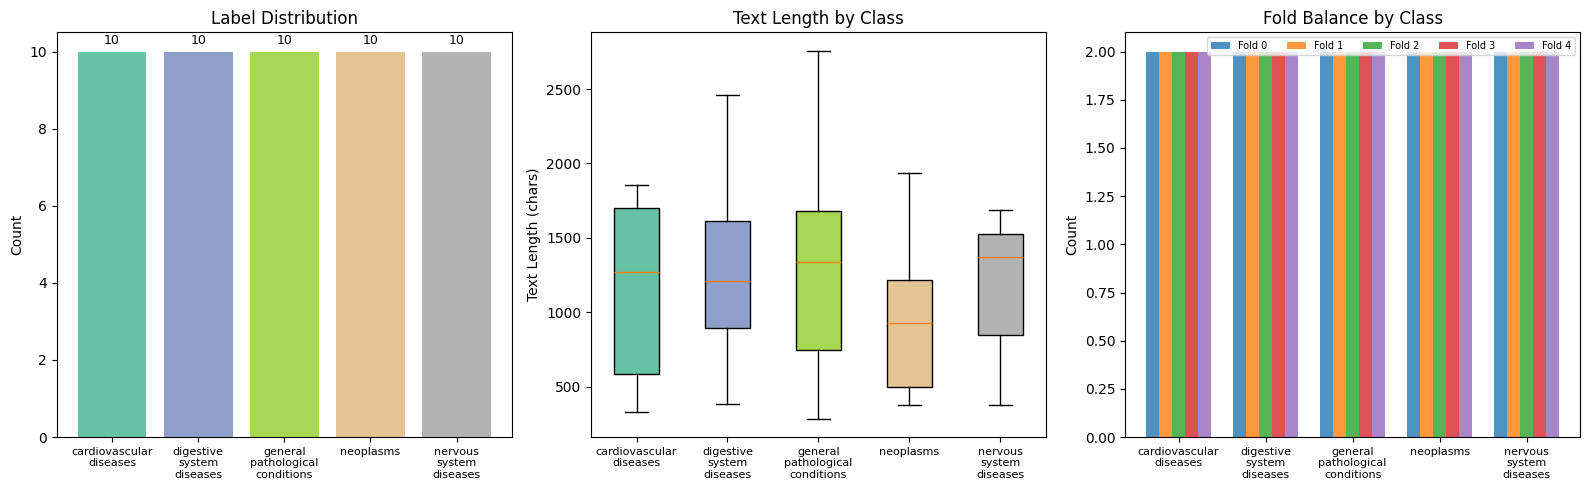

Saved: dataset_analysis.png

SUMMARY TABLE
Class                             Count   Mean Len    Med Len
------------------------------------------------------------
cardiovascular diseases              10       1180       1269
digestive system diseases            10       1280       1211
general pathological conditions      10       1388       1340
neoplasms                            10        971        931
nervous system diseases              10       1200       1370
------------------------------------------------------------
TOTAL                                50       1204       1228


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Label distribution
sorted_labels = sorted(label_dist.keys())
counts = [label_dist[lbl] for lbl in sorted_labels]
short_labels = [lbl.replace(' ', '\n') for lbl in sorted_labels]
colors = plt.cm.Set2(np.linspace(0, 1, len(sorted_labels)))
axes[0].bar(range(len(sorted_labels)), counts, color=colors)
axes[0].set_xticks(range(len(sorted_labels)))
axes[0].set_xticklabels(short_labels, fontsize=8)
axes[0].set_ylabel('Count')
axes[0].set_title('Label Distribution')
for i, c in enumerate(counts):
    axes[0].text(i, c + 0.2, str(c), ha='center', fontsize=9)

# 2. Text length distribution per class
class_lengths = {}
for ex in examples:
    cls = ex['output']
    if cls not in class_lengths:
        class_lengths[cls] = []
    class_lengths[cls].append(len(ex['input']))

bp_data = [class_lengths[lbl] for lbl in sorted_labels]
bp = axes[1].boxplot(bp_data, labels=short_labels, patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
axes[1].set_ylabel('Text Length (chars)')
axes[1].set_title('Text Length by Class')
axes[1].tick_params(axis='x', labelsize=8)

# 3. Fold distribution (stacked bar)
fold_counts = {}
for ex in examples:
    cls = ex['output']
    fold = ex['metadata_fold']
    if cls not in fold_counts:
        fold_counts[cls] = Counter()
    fold_counts[cls][fold] += 1

x = np.arange(len(sorted_labels))
width = 0.15
for fold_idx in range(N_SPLITS):
    fold_vals = [fold_counts.get(lbl, Counter()).get(fold_idx, 0)
                 for lbl in sorted_labels]
    axes[2].bar(x + fold_idx * width, fold_vals, width,
                label=f'Fold {fold_idx}', alpha=0.8)
axes[2].set_xticks(x + width * (N_SPLITS - 1) / 2)
axes[2].set_xticklabels(short_labels, fontsize=8)
axes[2].set_ylabel('Count')
axes[2].set_title('Fold Balance by Class')
axes[2].legend(fontsize=7, ncol=N_SPLITS)

plt.tight_layout()
plt.savefig('dataset_analysis.png', dpi=100, bbox_inches='tight')
plt.show()
print("Saved: dataset_analysis.png")

# Summary table
print("\n" + "=" * 60)
print("SUMMARY TABLE")
print("=" * 60)
print(f"{'Class':<32} {'Count':>6} {'Mean Len':>10} {'Med Len':>10}")
print("-" * 60)
for lbl in sorted_labels:
    lens = class_lengths[lbl]
    print(f"{lbl:<32} {len(lens):>6} {np.mean(lens):>10.0f} {np.median(lens):>10.0f}")
print("-" * 60)
print(f"{'TOTAL':<32} {len(examples):>6} {np.mean(text_lengths):>10.0f} {np.median(text_lengths):>10.0f}")